In [1]:
import sys
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
    
from sklearn.metrics.pairwise import cosine_similarity
import plotly.io as pio

In [2]:
from node2vec import Node2Vec

import networkx as nx

In [3]:

sys.path.append('../')

In [4]:
sys.path.append('/Users/charlesdedampierre/Desktop/Market Use Cases/bunkatrend/src/functions')

In [5]:
from networks import SemanticNetworks

In [6]:
from sys_utils import load_model
from data_model_region import Region
from data_model import Individual
import typing as t
import random

In [7]:
checkpoint_path = '../checkpoints_dev'

In [8]:
regions = load_model(
        Region, name=checkpoint_path+"/regions.jsonl"
    )

In [9]:
individuals = load_model(
        Individual, name=checkpoint_path + "/individuals.jsonl"
    )

In [93]:
ind = [x for x in individuals if x.id.wikidata_id == 'Q11385727']

In [11]:
# mistake

In [12]:
individuals_filtered = [x for x in individuals if x.regions != None]

df_individuals = [
    {
        "wikidata_id": x.id.wikidata_id,
        "name": x.id.name,
        "year": x.impact_years,
        "cultural_score": x.cultural_score,
        "region_code": x.regions,
        "occupation":[y.name for y in x.id.occupations]
    }
    for x in individuals_filtered
]

df_individuals = pd.DataFrame(df_individuals)
df_individuals = df_individuals.dropna()

In [13]:
test = df_individuals.explode('occupation')

In [14]:
df_individuals = df_individuals.explode('region_code')

In [87]:

reg = 're_japan'
reg = list(set(df_individuals.region_code))
df_filter = df_individuals[df_individuals['region_code'].isin(reg)].reset_index(drop=True)

df_filter["year"] = df_filter["year"].apply(
        lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)]
    )

df_filter = df_filter.explode('year')
df_filter = df_filter[df_filter['year']<=1800]

In [88]:
len(set(df_filter.wikidata_id))

70809

In [89]:
# get top occupations

In [90]:
df_top_occupation = df_filter[['wikidata_id', 'occupation']]
df_top_occupation= df_top_occupation.explode('occupation')
df_top_occupation = df_top_occupation.drop_duplicates().reset_index(drop=True)
top_occupations = df_top_occupation.occupation.value_counts().reset_index().head(2000)
top_occupations = list(top_occupations['index'])

In [91]:
top_occupations_fond = df_top_occupation.occupation.value_counts().reset_index().head(200)

In [92]:
top_occupations_fond.to_clipboard(index=False)

In [19]:
# where is writer ?

In [20]:
#top_occupations = ['mathematician','physicist', 'astronomer', 'philosopher', 'poet']

In [21]:
def get_mean_occupation(df_1):

    df_1 = df_1.drop('year', axis=1)
    df_1 = df_1.explode('occupation')
    df_1 = df_1[df_1['occupation'].isin(top_occupations)].reset_index(drop=True)
    df_1 = df_1.drop_duplicates()

    # get mean_occupatio for top 100 individuals
    df_1 = df_1.groupby(['wikidata_id', 'name', 'cultural_score'])['occupation'].apply(list).reset_index()
    df_1['count_occupations'] = df_1['occupation'].apply(lambda x : len(x))
    df_1 = df_1.sort_values('cultural_score', ascending=False)
    df_1 = df_1.head(100)
    mean_occupation = float(df_1[['count_occupations']].mean())
    
    return mean_occupation

In [22]:
df_1 = df_filter[df_filter['year']<=1500]
df_1 = df_filter[df_filter['year']>1500]
df_1 = df_1.drop('year', axis=1)
df_1 = df_1.explode('occupation')
#df_1 = df_1[df_1['occupation'].isin(top_occupations)].reset_index(drop=True)
df_1 = df_1.drop_duplicates()

# get mean_occupatio for top 100 individuals
df_1 = df_1.groupby(['wikidata_id', 'name', 'cultural_score'])['occupation'].apply(list).reset_index()
df_1['count_occupations'] = df_1['occupation'].apply(lambda x : len(x))
df_1 = df_1[df_1['count_occupations']>1]
df_1 = df_1.sort_values('cultural_score', ascending=False)
#df_1 = df_1.head(200)
mean_occupation = float(df_1[['count_occupations']].mean())

print(mean_occupation)

5.443608017817372


In [23]:
# Tu peux commencer par des pays à croissance forte : UK, France, Japan (1000 - 1800)


In [24]:
def coocurrence_multiple(data_network:pd.DataFrame(),index_var :str, variables:t.List[str]) -> pd.DataFrame:

        fin_list = []
        for var in variables:
            df_var = data_network[[index_var, var]]
            df_var = df_var.drop_duplicates()
            df_var = (
                df_var.groupby([index_var, var])[index_var]
                .count()
                .rename("weight")
                .reset_index()
            )
            df_var = df_var.rename(columns={var: "data"})
            df_var["entity"] = var
            fin_list.append(df_var)
        
        fin = pd.concat([x for x in fin_list])
        df_co = pd.merge(fin, fin, on=index_var)
        df_co["product"] = df_co["weight_x"] * df_co["weight_y"]
        edges = df_co.groupby(["data_x", "data_y"])["product"].sum().reset_index()
        edges.columns = ["source", "target", "weight"]

        return edges


def weight_to_similarity(edges:pd.DataFrame, global_filter: float = 0.7, n_neighbours: int = 6)->pd.DataFrame:

        pivot = edges.pivot("source", "target", "weight")
        pivot = pivot.fillna(0)
        similarity = cosine_similarity(pivot)  # compute cosine similarity
        df_sim = pd.DataFrame(similarity, index=pivot.index, columns=pivot.columns)
        df_sim = df_sim[(df_sim >= global_filter)]
        df_sim["nodes"] = df_sim.index

        res_g = pd.melt(df_sim, id_vars=["nodes"]).sort_values("nodes")  # time
        res_g = res_g.dropna()
        res_g.columns = ["source", "target", "weight"]
        res_g = res_g.sort_values("source")

        # Erase duplicates
        duplicates = []
        for x, y, i in zip(res_g.source, res_g.target, res_g.index):
            if x == y:
                duplicates.append(i)

        new_edge = res_g.drop(index=duplicates)
        new_edge = new_edge[new_edge.weight != 0]

        # Filter Neighbours
        new_edge["rank"] = new_edge.groupby(["source"])["weight"].rank(
            method="first", ascending=False
        )
        new_edge = new_edge[new_edge["rank"] <= n_neighbours]
        new_edge = new_edge.sort_values(['source', 'rank']).reset_index(drop=True)

        return new_edge

In [25]:
def compute_average(data:pd.DataFrame)->float:

    df_edge = coocurrence_multiple(data, index_var = 'wikidata_id', variables = ['occupation'])
    #df_new_edge = weight_to_similarity(df_edge, global_filter =  0, n_neighbours = 10)

    G = nx.from_pandas_edgelist(
                df_edge, source="source", target="target", edge_attr="weight"
            )

    node2vec = Node2Vec(G, dimensions=700, workers=5)
    model = node2vec.fit(window=30, min_count=1)

    nodes = list(map(str, G.nodes()))
    embeddings = np.array([model.wv[x] for x in nodes])
    df_embeddings = pd.DataFrame(embeddings)
    df_embeddings.index = nodes

    dist_cos = cosine_similarity(df_embeddings)
    dist_cos = pd.DataFrame(dist_cos, index=df_embeddings.index, columns=df_embeddings.index)

    average_mean = dist_cos.mean().mean()

    return average_mean, dist_cos

In [26]:
#500 #1500

In [27]:
load_occupations = pd.read_csv('Cultural Index - Clean top 50 occupations - data.csv')
load_occupations = load_occupations[load_occupations['exclude']!= 1]
load_occupations = list(load_occupations['index'])

In [73]:
n_top_individuals = 10000000
final_list = []
final_distances = []

year_range = np.arange(550, 1950, 100) 
ranges = [(start, start+100) for start in year_range[:-1]]

#ranges = [[500, 1000], [1000, 1500], [1500, 1850]]


ranges = [[800, 1000], [1000, 1200], [1200, 1400], [1500, 1600], [1600, 1800]]
ranges = [[500, 1500], [1500, 1800]]
#ranges = [[0, 1200],[1200, 1500], [1500, 1800]]

for rang in tqdm(ranges):
    
    try:

        df_filter_1 = df_filter[(df_filter['year']>=rang[0])&(df_filter['year']<=rang[1])]
        df_filter_1 = df_filter_1.explode('occupation')
        df_filter_1 = df_filter_1[df_filter_1['occupation'].isin(top_occupations)]
        #df_filter_1 = df_filter_1[df_filter_1['occupation'].isin(load_occupations)]
        
        df_filter_1 = df_filter_1.drop('year', axis=1).drop_duplicates()
        df_filter_1 = df_filter_1.sort_values('cultural_score', ascending=False).reset_index(drop=True)
        top_individuals = df_filter_1[['wikidata_id', 'cultural_score']].drop_duplicates()
        top_individuals = top_individuals.head(n_top_individuals)
        df_filter_1 = df_filter_1[df_filter_1['wikidata_id'].isin(top_individuals['wikidata_id'])]

        #random_ind = random.sample(list((set(df_filter_1.wikidata_id))), 100)
        #df_filter_1 = df_filter_1[df_filter_1['wikidata_id'].isin(random_ind)]

        mean, dist_cos = compute_average(df_filter_1)
        
        cosine_matrix = np.array(dist_cos)
        distances = cosine_matrix[np.triu_indices(len(cosine_matrix), k=1)]

        dict_res = {'range':rang, 
                'average_cosine_similarity':mean, 
                'count_individuals':len(set(df_filter_1['wikidata_id']))}
        final_list.append(dict_res)  
        
        new_dict = {'range':rang, 
                'cosine_similarity':distances}
        
        final_distances.append(new_dict)
        
    
    except:
        pass

  0%|                                                                                                                     | 0/2 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/285 [00:00<?, ?it/s]


 50%|██████████████████████████████████████████████████████▌                                                      | 1/2 [00:06<00:06,  6.17s/it]

Computing transition probabilities:   0%|          | 0/695 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.24s/it]


In [74]:
box_plots = pd.DataFrame(final_distances).explode('cosine_similarity').reset_index(drop=True)
box_plots['range_name'] = box_plots['range'].apply(lambda x : str(x[0])+'-'+str(x[1]))

In [75]:
box_plots.groupby('range_name')['cosine_similarity'].mean()

range_name
1500-1800    0.225080
500-1500     0.289415
Name: cosine_similarity, dtype: float64

In [76]:
# get the figure

In [81]:
fig = px.box(box_plots, x ='range_name', y = 'cosine_similarity', width = 400, height = 600, points = False)
fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.write_image(f"save_figures/box_plot.png", scale=7)

In [71]:
import scipy.stats as stats

# perform the t-test
t_stat, p_val = stats.ttest_ind(final_distances[0]['cosine_similarity'], final_distances[1]['cosine_similarity'])

# print the results
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 8.569943115876326
p-value: 4.593607010105503e-15


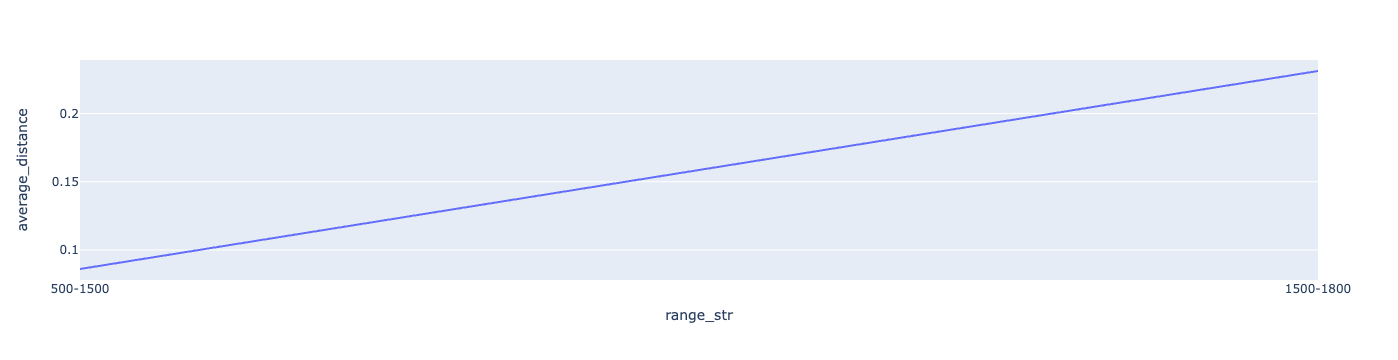

In [58]:
import plotly.express as px

res = pd.DataFrame(final_list)
res['average_distance'] = 1 - res['average_cosine_similarity']

res['range_str'] = res['range'].apply(lambda x : str(x[0]) + '-' + str(x[1]))
#fig = px.line(res, x = 'range_str', y = 'average_distance', width = 2000, title = reg)
fig = px.line(res, x = 'range_str', y = 'average_distance', width = 2000)

fig

In [34]:
# Compute the graph

In [35]:
import networkx as nx
import numpy as np
import pandas as pd
import multiprocessing
from collections import Counter
#import community as community_louvain
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
from node2vec import Node2Vec
import plotly.graph_objects as go
import community.community_louvain as community_louvain

class SemanticNetworks:
    def __init__(self, df, index_var, variables: list) -> None:
        self.data_network = df
        self.index_var = index_var
        self.variables = variables
        pass

    """
    Class made of a wide range of functions performing Networks analysis such as:
    - Graph Embeddings
    - Graph plots
    """

    def fit_draw(
        self,
        top_n=100,
        global_filter=0.2,
        n_neighbours=6,
        method="node2vec",
        n_cluster=10,
        bin_number=30,
        black_hole_force=1.5,
        color="community",
        size="size",
        symbol="entity",
        textfont_size=9,
        edge_size=1,
        height=1000,
        width=1000,
        template="plotly_dark",
    ):

        self.coocurrence_multiple()
        self.get_top_nodes(top_n=top_n)
        self.weight_to_similarity(
            global_filter=global_filter, n_neighbours=n_neighbours
        )

        self.compute_network(
            density=black_hole_force,
            bin_number=bin_number,
            method=method,
            n_cluster=n_cluster,
        )

        fig = self.draw_network(
            color=color,
            size=size,
            symbol=symbol,
            textfont_size=textfont_size,
            edge_size=edge_size,
            height_att=height,
            width_att=width,
            template=template,
        )

        return fig

    def coocurrence_multiple(self) -> pd.DataFrame:

        fin = pd.DataFrame()
        for var in self.variables:
            df_var = self.data_network[[self.index_var, var]]
            df_var = df_var.drop_duplicates()
            df_var = (
                df_var.groupby([self.index_var, var])[self.index_var]
                .count()
                .rename("weight")
                .reset_index()
            )
            df_var = df_var.rename(columns={var: "data"})
            df_var["entity"] = var
            fin = fin.append(df_var)

        self.fin = fin

        df_co = pd.merge(self.fin, self.fin, on=self.index_var)
        df_co["product"] = df_co["weight_x"] * df_co["weight_y"]
        self.edges = df_co.groupby(["data_x", "data_y"])["product"].sum().reset_index()
        self.edges.columns = ["source", "target", "weight"]

        return self.edges

    def get_top_nodes(self, top_n=300):

        # filter by top_n regarding their size
        nodes_attr = self.fin[[self.index_var, "data", "entity"]]
        nodes_attr = (
            nodes_attr.groupby(["data", "entity"])[self.index_var]
            .count()
            .rename("size")
            .reset_index()
        )
        nodes_attr = nodes_attr.sort_values("size", ascending=False).reset_index(
            drop=True
        )
        self.nodes_attr = nodes_attr.head(top_n)
        self.edges = self.edges[
            self.edges.source.isin(list(self.nodes_attr["data"]))
            & self.edges.target.isin(list(self.nodes_attr["data"]))
        ]

        return self.edges

    def weight_to_similarity(self, global_filter: float = 0.7, n_neighbours: int = 6):

        """

        This functions transform an edge list with weights into an edge list whose weights are cosine similarity

        parameters:
            - cooc_df with the following columns:
                - source
                - target
                - weight
            - global_filter: filter with minimum similarity
            - n_neighbours: filter with minimum neighbours

        output:
            - edge_list with the following columns:
                - source
                - target
                - weight (cosine similarity)
                - rank (closeness to the source)

        """

        pivot = self.edges.pivot("source", "target", "weight")
        pivot = pivot.fillna(0)
        similarity = cosine_similarity(pivot)  # compute cosine similarity
        df_sim = pd.DataFrame(similarity, index=pivot.index, columns=pivot.columns)
        df_sim = df_sim[(df_sim >= global_filter)]
        df_sim["nodes"] = df_sim.index

        res_g = pd.melt(df_sim, id_vars=["nodes"]).sort_values("nodes")  # time
        res_g = res_g.dropna()
        res_g.columns = ["source", "target", "weight"]
        res_g = res_g.sort_values("source")

        # Erase duplicates
        duplicates = []
        for x, y, i in zip(res_g.source, res_g.target, res_g.index):
            if x == y:
                duplicates.append(i)

        new_edge = res_g.drop(index=duplicates)
        new_edge = new_edge[new_edge.weight != 0]

        # Filter Neighbours
        new_edge["rank"] = new_edge.groupby(["source"])["weight"].rank(
            method="first", ascending=False
        )
        new_edge = new_edge[new_edge["rank"] <= n_neighbours]
        self.new_edge = new_edge.reset_index(drop=True)

        return self.new_edge

    def _get_community_name(self):
    
            # get a name for the clusters: the top 3 common terms
        df_nodes = self.df_node[['community', 'entity', 'size']].reset_index()
        df_nodes = df_nodes.rename(columns = {'index':'nodes'})
        df_nodes = df_nodes[df_nodes['entity']!= 'centroid']
        df_nodes = df_nodes.sort_values(['community', 'size'], ascending=(False, False))
        df_nodes_names = df_nodes.groupby('community').head(3)
        df_nodes_names = df_nodes_names.groupby('community')['nodes'].apply(lambda x: " | ".join(x)).reset_index()
        df_nodes_names = df_nodes_names.rename(columns = {'nodes':'cluster_name'})
        df_nodes = pd.merge(df_nodes, df_nodes_names, on = 'community')
        
        return df_nodes

    def _get_indexed_ids(self):

        try:
            var = [self.index_var] + self.variables
            df = self.data_network[var]

            df = df.rename(columns = {self.variables[0]:'nodes'})
            df_indexed_net = pd.merge(df, self.df_node, on = 'nodes')
            df_indexed_net = df_indexed_net.groupby([self.index_var, 'community'])['nodes'].count().reset_index()
            df_indexed_net = df_indexed_net.sort_values([self.index_var, 'nodes'], ascending=(False, False))
            df_indexed_net = df_indexed_net.groupby(self.index_var).head(1).reset_index(drop=True)
            df_indexed_net = df_indexed_net.rename(columns = {'nodes':'count_elements'})
        except:
            print("The indexed only works for one variable...")

        return df_indexed_net


    def compute_network(
        self,
        density: int = 2,
        bin_number: int = 30,
        method: str = "node2vec",
        n_cluster: int = 10,
    ):
        """This function takes edges as input and outputs a Networkx Object 'G' and
        coordiate

        Args:
            density (int, optional): density of the clusters force force-directed algorithm only. Defaults to 1.
            larger (int, optional): larger of the nodes_size . Defaults to 4.
            bin_number (int, optional):  number of bins to normalize the nodes' size. Defaults to 30.
            method (str, optional): node2vec or force_directed algorithm. Defaults to "node2vec".
            n_cluster (int, optional): [description]. Defaults to 20.

        Returns:
            [type]: Networkx G object and an array of coordinate for all the nodes in the Networkx G
        """

        def add_black_holes(G, density=2):

            # Add centroids in the middle of every 'community' and connects it to
            # all the nodes in the 'community'

            df_node = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")
            
            for community_number in set(df_node.community):

                G.add_node(
                    f"network_center_{community_number}",
                    community=community_number,
                    size=1,
                    entity="centroid",
                )

                list_nodes = list(
                    df_node[df_node["community"] == community_number].index
                )

                for node in list_nodes:
                    G.add_edge(
                        f"network_center_{community_number}", node, weight=density
                    )

            return G

        # Create Graph Object
        G = nx.from_pandas_edgelist(
            self.new_edge, source="source", target="target", edge_attr="weight"
        )
        

        # Compute centrality
        centrality = nx.degree_centrality(G)
        centrality = pd.DataFrame.from_dict(
            centrality, orient="index", columns=["centrality"]
        )

        centrality["centrality"] = pd.qcut(
            centrality["centrality"].rank(method="first"),
            bin_number,
            labels=range(1, bin_number + 1),
        )

        # add centrality attribute to the G object
        node_attr_centrality = centrality.to_dict("index")
        nx.set_node_attributes(G, node_attr_centrality)
        
        self.G = G

        if method == "force_directed":
            # Create the laout with Fruchterman-Reingold force-directed algorithm
            # Louvain community
            #partition = community_louvain.best_partition(G)
            #import community
            partition = community_louvain.best_partition(G)
            partition = pd.DataFrame.from_dict(
                partition, orient="index", columns=["community"]
            )

            # Add community attribute to the G object
            node_attr_community = partition.to_dict("index")
            nx.set_node_attributes(G, node_attr_community)
            G = add_black_holes(G, density=density)

            # Compute the coordinate of nodes based on specific force algorithm
            pos_ = nx.spring_layout(G)

            self.df_embeddings = pd.DataFrame(pos_).T
            self.df_embeddings.index = G.nodes()

        elif method == "node2vec":

            #node2vec = Node2Vec(G, dimensions=700, workers=multiprocessing.cpu_count())
            node2vec = Node2Vec(G, dimensions=700, workers=5)
            model = node2vec.fit(window=30, min_count=1)
            nodes = list(map(str, G.nodes()))
            embeddings = np.array([model.wv[x] for x in nodes])

            # Get the community with embeddings
            cluster_model = KMeans(n_clusters=n_cluster)
            community = cluster_model.fit_predict(embeddings)

            partition = pd.DataFrame(index=nodes)
            partition["community"] = community

            # Add community attribute to the G object
            node_attr_community = partition.to_dict("index")
            nx.set_node_attributes(G, node_attr_community)
            G = add_black_holes(G, density=density)

            # Re-compute to add the new nodes and get their
            node2vec = Node2Vec(G, dimensions=700, workers=multiprocessing.cpu_count())
            model = node2vec.fit(window=30, min_count=1)
            nodes = list(map(str, G.nodes()))
            embeddings = np.array([model.wv[x] for x in nodes])

            # Get the 2D embeddings to display data
            #tsne = TSNE(n_components=2,  perplexity=5)
            tsne = umap.UMAP(n_components=2)

            embeddings = tsne.fit_transform(embeddings)
            pos_ = {nodes[x]: embeddings[x] for x in range(len(nodes))}

            self.df_embeddings = pd.DataFrame(embeddings)
            self.df_embeddings.index = nodes

        self.G = G
        self.pos_ = pos_

        self.df_node = pd.DataFrame.from_dict(
            dict(self.G.nodes(data=True)), orient="index"
        )

    def draw_network(
        self,
        color="entity",
        size="size",
        symbol=None,
        textfont_size=9,
        edge_size=3,
        height_att=1000,
        width_att=1000,
        template="plotly_dark",
    ):
        """Output a Graph

        Args:
            color (str, optional): chose in the nodes attribute the column_name for colors. Defaults to "entity".
            size (str, optional): chose in the nodes attribute the column_name for size. Defaults to "size".
            symbol ([type], optional): [description]. Defaults to None.
        """

        # Deal the size of the centroids (as they do not come from the nodes_attr)
        clusters = [
            self.G.nodes(data=True)[x]["community"] for x in list(self.G.nodes())
        ]
        clusters = dict(Counter(clusters))

        # Add the entities and the size
        df_nodes = self.nodes_attr.set_index("data")
        df_nodes["entity"] = df_nodes["entity"].astype("category").cat.codes
        bin_number = 30
        df_nodes["size"] = pd.cut(
            df_nodes["size"].rank(method="first"),
            bin_number,
            labels=range(1, bin_number + 1),
        )

        node_attr = df_nodes.to_dict("index")
        nx.set_node_attributes(self.G, node_attr)

        self.df_node = pd.DataFrame.from_dict(
            dict(self.G.nodes(data=True)), orient="index"
        )
        self.df_node = pd.merge(
            self.df_embeddings, self.df_node, left_index=True, right_index=True
        )

        # For each edge, make an edge_trace, append to list
        edge_trace = []
        for edge in self.G.edges():

            if self.G.edges()[edge]["weight"] > 0:
                x0, y0 = self.pos_[edge[0]]
                x1, y1 = self.pos_[edge[1]]

                """text = (
                    char_1 + "--" + char_2 + ": " + str(self.G.edges()[edge]["weight"])
                )"""

                if "network_center_" in edge[0]:
                    width = 0
                elif "network_center_" in edge[1]:
                    width = 0

                else:
                    # The bigger the node, the bigger the edge width
                    width = edge_size * self.G.edges()[edge]["weight"] ** 1.75

                trace = go.Scatter(
                    x=[x0, x1, None],
                    y=[y0, y1, None],
                    line=dict(width=width, color="cornflowerblue"),
                    mode="lines",
                )
                # fig.add_trace(trace)
            edge_trace.append(trace)

        # Make a node trace
        node_trace = go.Scatter(
            x=[],
            y=[],
            text=[],
            textposition="top center",
            textfont_size=textfont_size,
            mode="markers+text",
            hoverinfo="text",
            marker=dict(color=[], size=[], line=None, opacity=[], symbol=[]),
        )

        # For each nodeget the position and size and add to the node_trace
        for node in self.G.nodes():

            if "network_center_" in node:
                continue

            x, y = self.pos_[node]
            node_trace["x"] += tuple([x])
            node_trace["y"] += tuple([y])
            node_trace["marker"]["color"] += tuple([self.G.nodes()[node][color]])

            if symbol is None:
                node_trace["marker"]["symbol"] = "circle"
            else:
                node_trace["marker"]["symbol"] += tuple([self.G.nodes()[node][symbol]])

            node_trace["text"] += tuple(["<b>" + node + "</b>"])
            node_trace["marker"]["opacity"] += tuple([0.6])
            node_trace["marker"]["size"] += tuple([self.G.nodes()[node][size]])

        # Customize layout
        layout = go.Layout(
            height=height_att,
            width=width_att,
            title="Semantic Network",
            xaxis={"showgrid": False, "zeroline": False},  # no gridlines
            yaxis={"showgrid": False, "zeroline": False},  # no gridlines
        )

        # Create figure
        fig = go.Figure(layout=layout)

        # Add the traces
        for trace in edge_trace:
            fig.add_trace(trace)

        fig.add_trace(node_trace)
        fig.update_layout(showlegend=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(template=template)


        # Give clusters a name
        self.df_topic_name = self._get_community_name()
        self.df_topic_name = self.df_topic_name[['nodes', 'cluster_name']]
        self.df_node = self.df_node.reset_index()
        self.df_node = self.df_node.rename(columns = {'index':'nodes'})
        self.df_node = pd.merge(self.df_topic_name, self.df_node, on = 'nodes')


        self.df_indexed_net  = self._get_indexed_ids()
    
        return fig

In [36]:
df_top_occupation.occupation.value_counts().reset_index().head(50).to_clipboard(index=False)

In [37]:
load_occupations = pd.read_csv('Cultural Index - Clean top 50 occupations - data.csv')
load_occupations = load_occupations[load_occupations['exclude']!= 1]
load_occupations = list(load_occupations['index'])

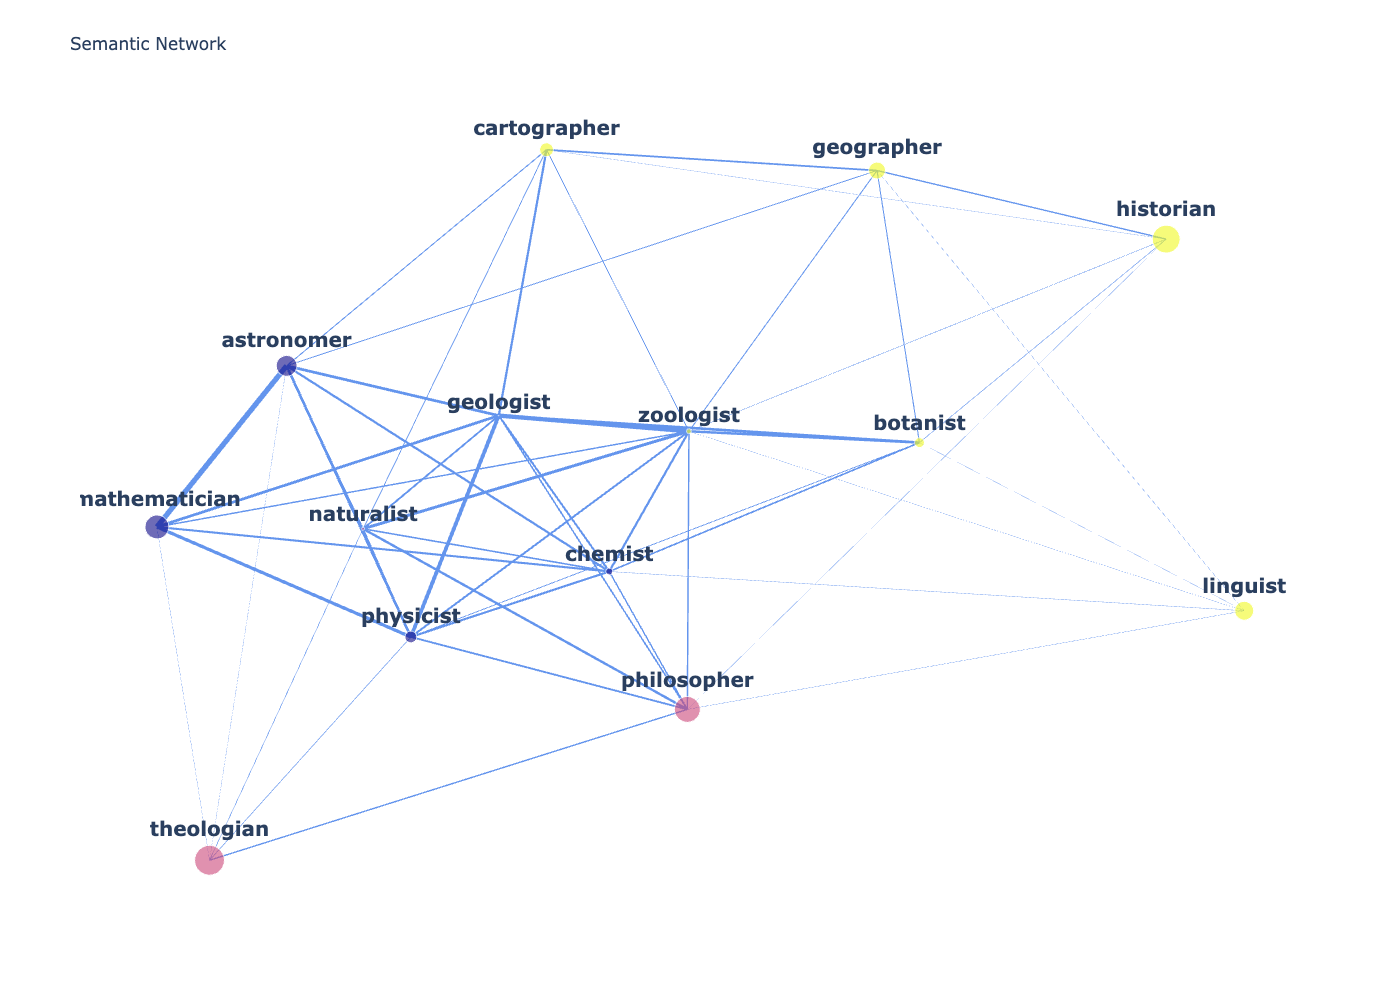

In [47]:
new_top_occupations = df_top_occupation.occupation.value_counts().reset_index().head(50)
new_top_occupations = list(new_top_occupations['index'])

rang = ranges[0]

df_filter_1 = df_filter[(df_filter['year']>=rang[0])&(df_filter['year']<=rang[1])]
df_filter_1 = df_filter_1.explode('occupation')
df_filter_1 = df_filter_1[df_filter_1['occupation'].isin(load_occupations)]
df_filter_1 = df_filter_1.drop('year', axis=1).drop_duplicates()
df_filter_1 = df_filter_1.sort_values('cultural_score', ascending=False).reset_index(drop=True)
top_individuals = df_filter_1[['wikidata_id', 'cultural_score']].drop_duplicates()
top_individuals = top_individuals.head(n_top_individuals)
df_filter_1 = df_filter_1[df_filter_1['wikidata_id'].isin(top_individuals['wikidata_id'])]
df_filter_1 = df_filter_1[['wikidata_id', 'occupation']].drop_duplicates()

model = SemanticNetworks(df_filter_1, index_var = 'wikidata_id', variables = ['occupation'])

fig = model.fit_draw(
        top_n=50,
        global_filter=0,
        n_neighbours=5,
        method="force_directed",
        n_cluster=1,
        bin_number=30,
        black_hole_force=0,
        color="community",
        size="size",
        symbol="entity",
        textfont_size=20,
        edge_size=7,
        height=1000,
        width=1000,
        template="plotly_white",
    )

fig.show()

name = str(rang[0]) + '-' + str(rang[1])
# Enregistrer l'image en PNG haute qualité
fig.write_image(f"save_figures/{name}.png", width=800, height=800, scale=7)

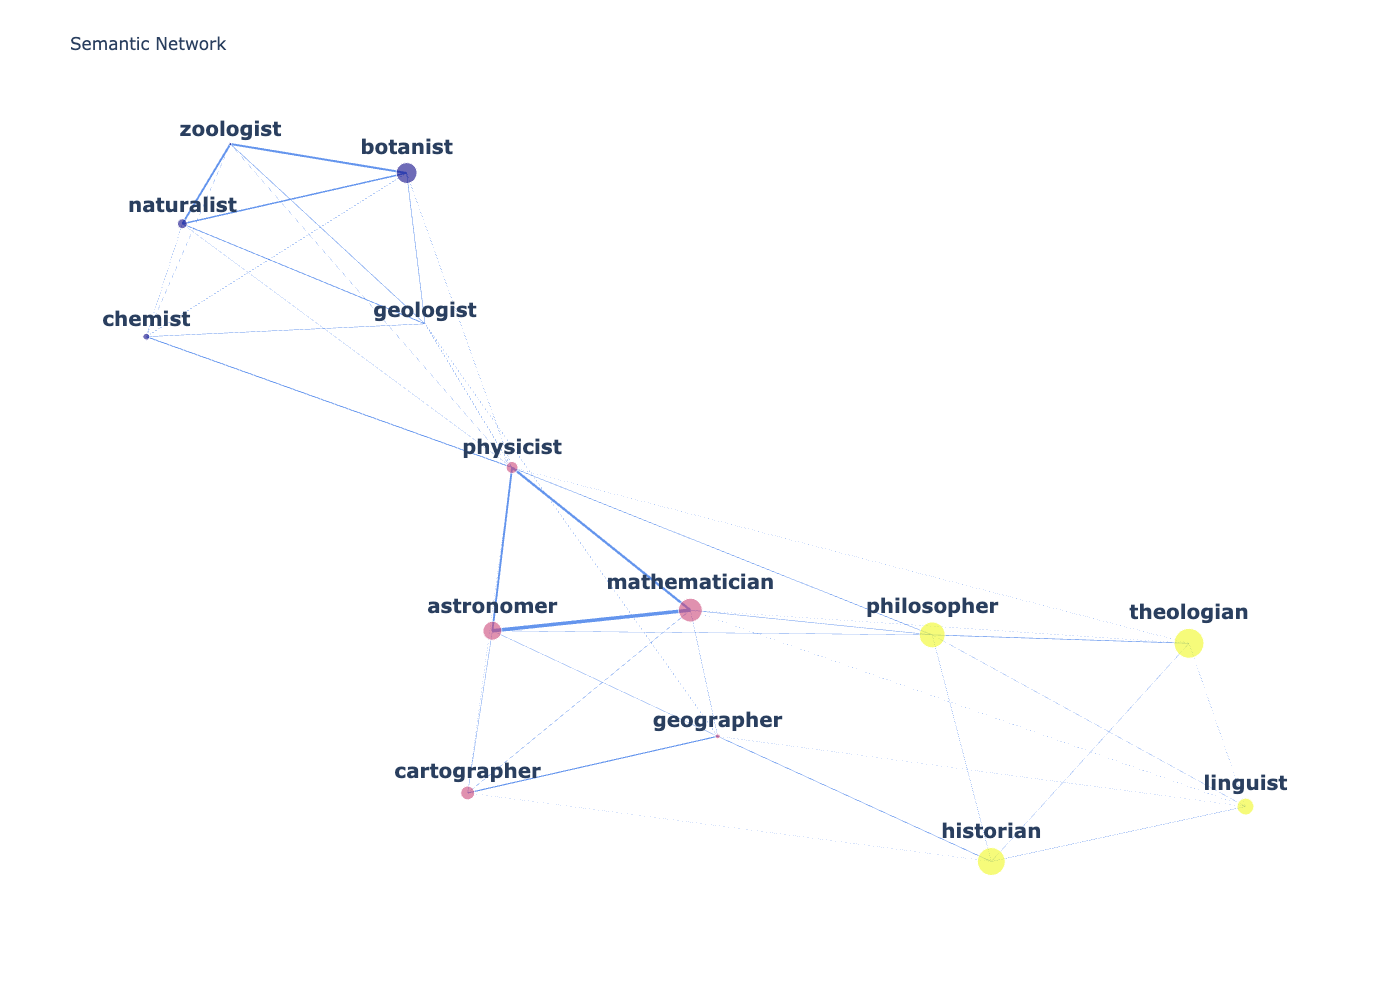

In [54]:
rang = ranges[1]

df_filter_1 = df_filter[(df_filter['year']>=rang[0])&(df_filter['year']<=rang[1])]
df_filter_1 = df_filter_1.explode('occupation')
df_filter_1 = df_filter_1[df_filter_1['occupation'].isin(load_occupations)]
df_filter_1 = df_filter_1.drop('year', axis=1).drop_duplicates()
df_filter_1 = df_filter_1.sort_values('cultural_score', ascending=False).reset_index(drop=True)
top_individuals = df_filter_1[['wikidata_id', 'cultural_score']].drop_duplicates()
top_individuals = top_individuals.head(n_top_individuals)
df_filter_1 = df_filter_1[df_filter_1['wikidata_id'].isin(top_individuals['wikidata_id'])]
df_filter_1 = df_filter_1[['wikidata_id', 'occupation']].drop_duplicates()

model = SemanticNetworks(df_filter_1, index_var = 'wikidata_id', variables = ['occupation'])

fig = model.fit_draw(
        top_n=50,
        global_filter=0,
        n_neighbours=5,
        method="force_directed",
        n_cluster=1,
        bin_number=30,
        black_hole_force=0,
        color="community",
        size="size",
        symbol="entity",
        textfont_size=20,
        edge_size=7,
        height=1000,
        width=1000,
        template="plotly_white",
    )

fig.show()

name = str(rang[0]) + '-' + str(rang[1])
# Enregistrer l'image en PNG haute qualité
fig.write_image(f"save_figures/{name}.png", width=800, height=800, scale=7)

In [42]:
# proportion de sciences durs

In [43]:
# graph de box plot

In [44]:
res

,range,average_cosine_similarity,count_individuals,average_distance,range_str
0,"[500, 1500]",0.913851,2859,0.086149,500-1500
1,"[1500, 1800]",0.768816,17627,0.231184,1500-1800


In [45]:
# en moyenne les occupations co-occurent de moins en moins. Qaund deux corrélation corrèlent, leur proximité
# sémantique est très proche. Les occupations sont globalemet de moins en moins proches
# leur distance est donc de plus en plus grande. Or une grande distance entre les occupations et signe
# d'une baisse de la co-occurence et donc par définition d'une spécialisation des individus.

# les individus ont des occupatiosn de plus en plus séparés des unes des unes des autres. 